# Analyzing time series

While the Raven server specializes in hydrological modeling, the Finch server specializes in climate indicators, some of which are useful for stream flow series analysis. 

Here we'll test those indicators on a simple test file with around ten years of daily streamflow generated by a Raven simulation.

In [1]:
%matplotlib inline

import os

import xarray as xr
import xclim
from pandas.plotting import register_matplotlib_converters

from ravenpy.utilities.testdata import get_file

register_matplotlib_converters()

fn = get_file("hydro_simulations/raven-gr4j-cemaneige-sim_hmets-0_Hydrographs.nc")
ds = xr.open_dataset(fn)

## Base flow index

The base flow index is the minimum 7-day average flow divided by the mean flow. 

In [2]:
help(xclim.land.base_flow_index)

Help on BASE_FLOW_INDEX in module xclim.indicators.land._streamflow:

<xclim.indicators.land._streamflow.BASE_FLOW_INDEX object>
    Base flow index (realm: land)
    
    Return the base flow index, defined as the minimum 7-day average flow divided by the mean flow.
    
    This indicator will check for missing values according to the method "from_context".
    Based on indice :py:func:`~xclim.indices._hydrology.base_flow_index`.
    
    Parameters
    ----------
    q : str or DataArray
      Rate of river discharge.
      Default : `ds.q`. [Required units : [discharge]]
    freq : offset alias (string)
      Resampling frequency.
      Default : YS. 
    ds : Dataset, optional
      A dataset with the variables given by name.
      Default : None. 
    
    Returns
    -------
    base_flow_index : DataArray
      Base flow index, with additional attributes: **description**: Minimum of the 7-day moving average flow divided by the mean flow.
    Notes
    -----
    Let :math:`\math

The base flow index needs as input arguments the link to a NetCDF file storing the stream flow time series, the name of the stream flow variable, and the frequency at which the index is computed (`YS`: yearly, `QS-DEC`: seasonally). 

/home/david/.conda/envs/ravenpy39/lib/python3.10/site-packages/xclim/indicators/land/_streamflow.py:30: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(q, "standard_name", "water_volume_transport_in_river_channel")


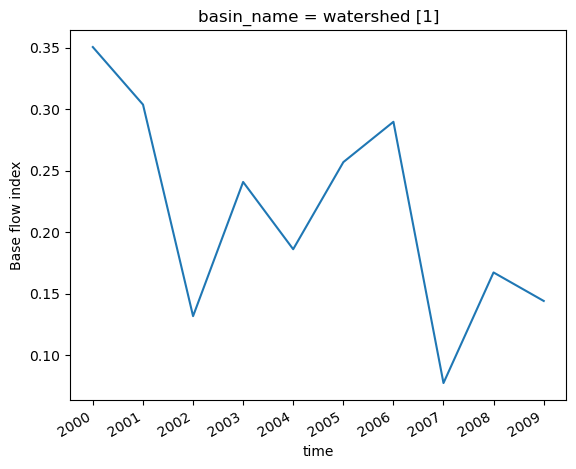

In [3]:
out = xclim.land.base_flow_index(ds.q_sim)
out.plot()

To compute generic statistics of a time series, use the `stats` process.

In [4]:
help(xclim.generic.stats)

Help on STATS in module xclim.core.indicator:

<xclim.core.indicator.STATS object>
    Statistic of the daily values for a given period. (realm: generic)
    
    
    
    This indicator will check for missing values according to the method "any".
    Based on indice :py:func:`~xclim.indices.generic.select_resample_op`.
    
    Parameters
    ----------
    da : str or DataArray
      Input data.
      Default : `ds.da`. 
    op : {'sum', 'min', 'mean', 'argmax', 'var', 'argmin', 'max', 'count', 'std'}
      Reduce operation. Can either be a DataArray method or a function that can be applied to a DataArray.
      Default : `ds.da`. 
    freq : offset alias (string)
      Resampling frequency defining the periods as defined in https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling.
      Default : YS. 
    ds : Dataset, optional
      A dataset with the variables given by name.
      Default : None. 
    indexer : 
      Time attribute and values over which

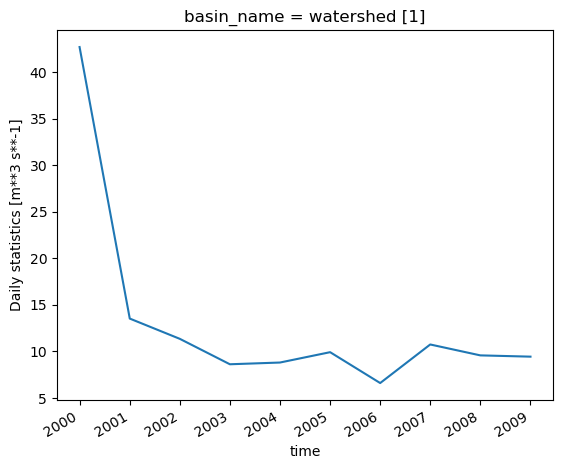

In [5]:
# Here we compute the annual summer (JJA) minimum
out = xclim.generic.stats(ds.q_sim, op="min", season="JJA")
out.plot()

## Frequency analysis

The process `freq_analysis` is similar to the previous stat sin the it fits a series of annual maxima or minima to a statistical distribution, and returns the values corresponding to different return periods. 

In [6]:
help(xclim.generic.return_level)

Help on RETURN_LEVEL in module xclim.core.indicator:

<xclim.core.indicator.RETURN_LEVEL object>
    Return level from frequency analysis (realm: generic)
    
    Frequency analysis on the basis of a given mode and distribution.
    
    This indicator will check for missing values according to the method "skip".
    Based on indice :py:func:`~xclim.indices.stats.frequency_analysis`.
    
    Parameters
    ----------
    da : str or DataArray
      Input data.
      Default : `ds.da`. 
    mode : {'min', 'max'}
      Whether we are looking for a probability of exceedance (high) or a probability of non-exceedance (low).
      Default : `ds.da`. 
    t : number or sequence of numbers
      Return period. The period depends on the resolution of the input data. If the input array's resolution is yearly, then the return period is in years.
      Default : `ds.da`. 
    dist : str
      Name of the univariate distribution, e.g. `beta`, `expon`, `genextreme`, `gamma`, `gumbel_r`, `lognorm`,

For example, computing the Q(2,7), the minimum 7-days streamflow of reccurrence two years, can be done using the following. 

In [7]:
out = xclim.generic.return_level(ds.q_sim, mode="min", t=2, dist="gumbel_r", window=7)
out

<xarray.DataArray 'fa_7minannual' (return_period: 1, nbasins: 1)>
array([[8.88305646]])
Coordinates:
    basin_name     (nbasins) object ...
  * return_period  (return_period) int64 2
Dimensions without coordinates: nbasins
Attributes:
    units:               m**3 s**-1
    original_long_name:  Simulated outflows
    long_name:           N-year return level
    description:         Frequency analysis for the minimal annual 7-day valu...
    method:              ML
    estimator:           Maximum likelihood
    scipy_dist:          gumbel_r
    history:             [2023-03-30 17:13:40] fa_7minannual: xclim.core.indi...
    cell_methods:        
    mode:                min

An array of return periods can be passed. 

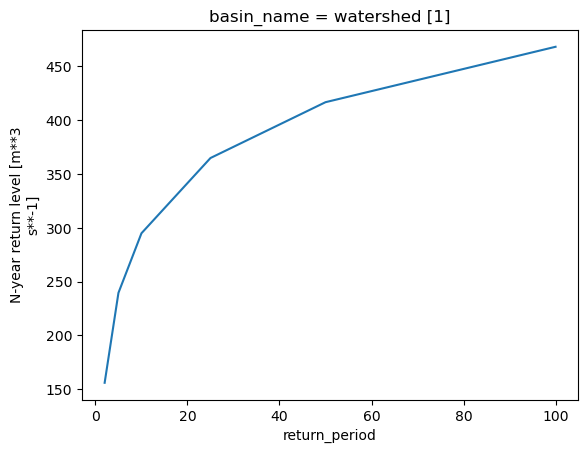

In [8]:
out = xclim.generic.return_level(
    ds.q_sim, mode="max", t=(2, 5, 10, 25, 50, 100), dist="gumbel_r"
)
out.plot()

## Getting the parameters of the distribution and comparing the fit

It's sometimes more useful to store the fitted parameters of the distribution rather than storing only the quantiles. In the example below, we're first computing the annual maxima of the simulated time series, then fitting them to a gumbel distribution using the `fit` process. 

In [9]:
import json

with xclim.set_options(
    check_missing="pct", missing_options={"pct": {"tolerance": 0.05}}
):
    ts = xclim.generic.stats(ds.q_sim, op="max")

ts

<xarray.DataArray 'stat_annualmax' (time: 11, nbasins: 1)>
array([[338.27670973],
       [142.89774096],
       [225.27578851],
       [145.49666036],
       [158.07738057],
       [125.56824572],
       [104.49135515],
       [206.67267598],
       [176.02003628],
       [191.89671866],
       [         nan]])
Coordinates:
    basin_name  (nbasins) object 'watershed'
  * time        (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2010-01-01
Dimensions without coordinates: nbasins
Attributes:
    units:         m**3 s**-1
    long_name:     Daily statistics
    cell_methods:  
    history:       [2023-03-30 17:13:40] stat_annualmax: xclim.core.indicator...
    description:   Annual maximal of daily values (annual).

In [11]:
with xclim.set_options(check_missing="skip"):
    pa = xclim.generic.fit(ts.isel(nbasins=0), dist="gumbel_r")
pa

<xarray.DataArray 'params' (dparams: 2)>
array([154.27106249,  44.07163054])
Coordinates:
    basin_name  object 'watershed'
  * dparams     (dparams) <U5 'loc' 'scale'
Attributes:
    original_units:        m**3 s**-1
    original_long_name:    Daily statistics
    cell_methods:           time: fit
    history:               [2023-03-30 17:13:40] stat_annualmax: xclim.core.i...
    original_description:  Annual maximal of daily values (annual).
    long_name:             Gumbel_r distribution parameters
    description:           Parameters of the gumbel_r distribution.
    method:                ML
    estimator:             Maximum likelihood
    scipy_dist:            gumbel_r
    units:                 
    standard_name:         gumbel_r parameters

To see how the distribution defined by those parameters compare with the original data, Raven's `graph_fit` process can help by creating a graphic showing an histogram of the data, overlayed with the fitted probability density function. The left y-axis displays the density (pdf) while the right y-axis displays the histogram count.  

In [ ]:
# resp = raven.graph_fit(ts=ts, params=pa_fn)
# resp.get(asobj=True)[0]